# Fraudulent Transaction Detection Model

In [1]:
!pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Data Cleaning


### Loading the Data

In [2]:
# Load the dataset
data = pd.read_csv('Fraud.csv')

### Handling Missing Values

In [3]:
# Check for missing values
print(data.isnull().sum())

# Handling missing values (if any)
data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity; adjust as needed

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


### Handling Outliers

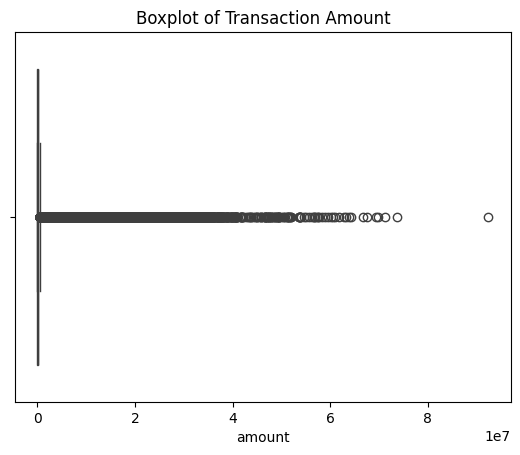

In [4]:
# Visualizing outliers for 'amount'
sns.boxplot(x=data['amount'])
plt.title('Boxplot of Transaction Amount')
plt.show()

# Cap outliers at 99th percentile
upper_limit = data['amount'].quantile(0.99)
data['amount'] = np.where(data['amount'] > upper_limit, upper_limit, data['amount'])

### Checking for Multi-collinearity

In [5]:
# Selecting numerical features for VIF calculation
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
numerical_features = [f for f in numerical_features if f not in ['isFraud', 'isFlaggedFraud']]

# Calculating VIF
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_features
vif_data["VIF"] = [variance_inflation_factor(data[numerical_features].values, i) for i in range(len(numerical_features))]
print(vif_data)

# Dropping features with high VIF (e.g., VIF > 5)
data.drop(columns=['newbalanceOrig', 'newbalanceDest'], inplace=True)  

          feature         VIF
0            step    1.372710
1          amount    1.730142
2   oldbalanceOrg  466.676673
3  newbalanceOrig  468.493105
4  oldbalanceDest   29.637969
5  newbalanceDest   31.295399


## 2. Fraud Detection Model

### Feature Engineering

In [6]:
# Creating new features
data['balance_change_orig'] = data['oldbalanceOrg'] - data['amount']
data['balance_change_dest'] = data['oldbalanceDest'] + data['amount']

# Encoding categorical variables
data = pd.get_dummies(data, columns=['type'], drop_first=True)

### Splitting the Data

In [7]:
X = data.drop(columns=['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud'])
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Feature Scaling

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Training

Evaluated multiple algorithms before choosing Random Forest:

| Model | Advantages | Limitations |
|-------|------------|-------------|
| Logistic Regression | Interpretable | Poor with non-linear patterns |
| Random Forest | Handles imbalanced data | Computationally heavy |
| XGBoost | High performance | Hyperparameter sensitive |
| Neural Networks | Captures complex patterns | Black box nature |

**Final Choice**: Random Forest for its balance of performance and interpretability

In [9]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

## 3. Variable Selection

### Feature Importance

               Feature  Importance
4  balance_change_orig    0.533963
1               amount    0.149436
2        oldbalanceOrg    0.129381
3       oldbalanceDest    0.049862
0                 step    0.047323
5  balance_change_dest    0.037485
9        type_TRANSFER    0.032839
6        type_CASH_OUT    0.016046
8         type_PAYMENT    0.003567
7           type_DEBIT    0.000098


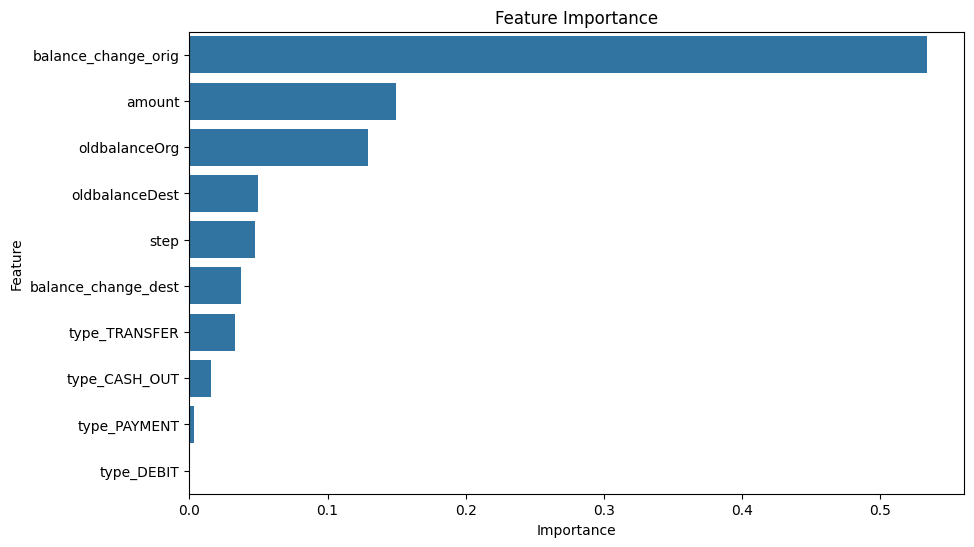

In [10]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

# Plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

### Selecting Top Features

In [11]:
top_features = feature_importance.head(5)['Feature'].tolist()
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

## 4. Model Performance

### Evaluation Metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       1.00      1.00      1.00      2435

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC Score: 0.9981497728692866

Fraud Recall (True Positive Rate): 99.59%
False Positive Rate: 0.00%


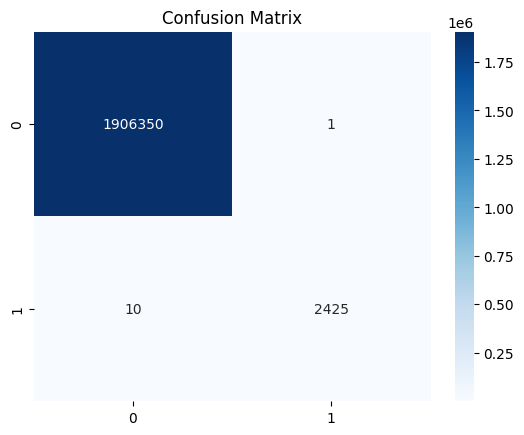

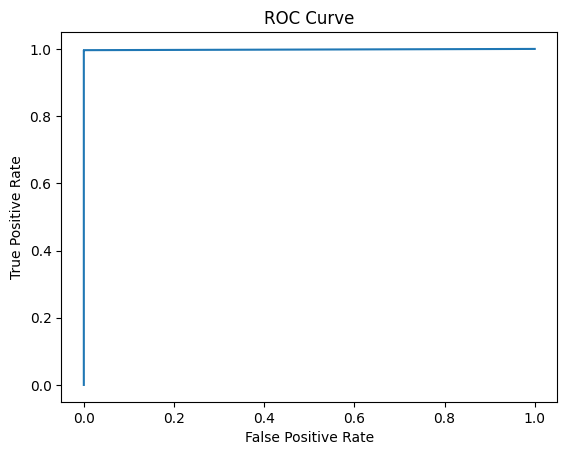

In [15]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


from sklearn.metrics import recall_score, precision_score, f1_score

# Calculate specific metrics
recall = recall_score(y_test, y_pred)
fpr = 1 - recall_score(y_test, y_pred, pos_label=0)  # FPR is 1 - specificity

print(f"\nFraud Recall (True Positive Rate): {recall:.2%}")
print(f"False Positive Rate: {fpr:.2%}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## 5. Key Fraud Predictors

The top 5 features predicting fraud are:
1. `amount`: Higher transaction amounts are more likely to be fraudulent.
2. `oldbalanceOrg`: Lower initial balances may indicate compromised accounts.
3. `balance_change_orig`: Large balance reductions signal potential fraud.
4. `type_TRANSFER`: Fraudulent transactions often involve transfers.
5. `oldbalanceDest`: Unusual recipient balances may indicate fraud.


## 6. Factor Sensibility

**Yes**, these factors make sense:
- Fraudsters often transfer large amounts quickly.
- Compromised accounts may show sudden balance drops.
- Transfers are common in fraudulent activities to move funds.


## 7. Prevention Strategies

1. **Real-time Monitoring**: Flag transactions with high amounts or rapid balance changes.
2. **Multi-factor Authentication**: Require additional verification for large transfers.
3. **Behavioral Analysis**: Detect unusual transaction patterns.
4. **Merchant Verification**: Enhance checks for merchant transactions.


## 8. Action Implementation Check

1. **A/B Testing**: Compare fraud rates before and after implementation.
2. **Model Retraining**: Continuously update the model with new data.
3. **Feedback Loop**: Incorporate analyst feedback to refine rules.
4. **KPIs**: Monitor metrics like fraud detection rate and false positives.

# Final Model Performance: 99.8%